In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.model_selection import GridSearchCV

In [280]:
import wandb

wandb.login()

True

## raw-data

In [281]:
train_raw_data = pd.read_csv('raw-data/train.csv')
test_raw_data = pd.read_csv('raw-data/test.csv')
val_raw_data = pd.read_csv('raw-data/valid.csv')

In [282]:
def split_raw_data(data):
    # select first 8000 rows as training data (labeled data)
    label_data = data.iloc[:8000, :]

    # drop the rows with missing mean_salary
    data.drop([np.where(data['requirements_and_role'].isnull())[0][0]], inplace=True)

    # drop the job_id column
    data.drop(['job_id'], axis=1, inplace=True)

    # reset the index
    data = data.reset_index(drop=True)

    return data

In [283]:
train_raw_data = clean_raw_data(train_raw_data)
print(train_raw_data.shape)

(7999, 4)


## embeddings-data


384-dimensional embeddings -> job description (vecrtor)

In [284]:
train_emb_data = np.load('embeddings-data/train-embeddings.npy')
val_emb_data = np.load('embeddings-data/valid-embeddings.npy')
test_emb_data = np.load('embeddings-data/test-embeddings.npy')

In [285]:
def clean_emb_data(data, train_raw_data):
    # select first 8000 rows as training data (labeled data)
    data = data[:8000, :]

    # delete the rows with missing mean_salary
    data = np.delete(data, 7418, axis=0)

    return data

In [286]:
train_emb_data = clean_emb_data(train_emb_data, train_raw_data)

In [287]:
train_emb_data.shape

(7999, 384)

## Basel Line - KNN

In [250]:
from sklearn.neighbors import KNeighborsRegressor

# KNN regression
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(train_emb_data, train_raw_data['salary_bin'])
knn_reg_pred = knn_reg.predict(val_emb_data)




In [251]:
# wandb.init()

In [ ]:
# print("Best parameters found: ", grid_search.best_params_)
# print("Best score found: ", grid_search.best_score_)


Best parameters found:  {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
Best score found:  0.23790314258911818


In [271]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=30, weights='distance', algorithm='kd_tree')
knn_clf.fit(train_emb_data, train_raw_data['salary_bin'])
knn_clf_pred = knn_clf.predict(val_emb_data)

print(knn_clf.score(val_emb_data, val_raw_data['salary_bin']))

0.24006908462867013


In [253]:
from sklearn.neighbors import KNeighborsRegressor

# score_list = []
# for i in range(1,50):
#     knn = KNeighborsRegressor(n_neighbors=i)
#     knn.fit(train_emb_data, train_raw_data['salary_bin'])
#     score_list.append(knn.score(val_emb_data, val_raw_data['salary_bin']))

# plt.figure(figsize=[8, 4])
# plt.xlabel('k')
# plt.ylabel('accuracy')
# plt.title('k-NN: Varying Number of Neighbors')
# plt.plot(range(1,50), score_list)
# plt.show()

## SVC


In [274]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(), SVC(kernel='linear',gamma='auto'))
clf.fit(train_emb_data, train_raw_data['salary_bin'])

score = clf.score(val_emb_data, val_raw_data['salary_bin'])
print(score)

0.20840529648819806


## Bayes

In [275]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(train_emb_data, train_raw_data['salary_bin'])

score = clf.score(val_emb_data, val_raw_data['salary_bin'])
print(score)

0.229706390328152


## Decision Tree

In [276]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0, max_depth=10)
model.fit(train_emb_data, train_raw_data['salary_bin'])

score = model.score(val_emb_data, val_raw_data['salary_bin'])
print(score)

0.17501439263097293


## random forest

In [277]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train_emb_data, train_raw_data['salary_bin'])

score = clf.score(val_emb_data, val_raw_data['salary_bin'])
print(score)

0.204951065054692


## TF

In [213]:
train_data_np = np.array(train_emb_data).astype(np.float32)  # Assuming train_raw_data is a pandas DataFrame
train_labels_np = np.array(train_raw_data['salary_bin']).astype(np.int32)

test_data_np = np.array(val_emb_data).astype(np.float32)  # Assuming test_raw_data is a pandas DataFrame
test_labels_np = np.array(val_raw_data['salary_bin']).astype(np.int32)


num_classes = len(np.unique(train_labels_np))

train_labels_one_hot = tf.keras.utils.to_categorical(train_labels_np, num_classes)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_np, num_classes)


In [214]:
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((384, 1), input_shape=(384,)),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [215]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_data_np, train_labels_one_hot, epochs=50, batch_size=64, validation_data=(test_data_np, test_labels_one_hot), callbacks=[early_stopping])


Epoch 1/50
125/125 [==============================] - 11s 81ms/step - loss: 2.3021 - accuracy: 0.1020 - val_loss: 2.3008 - val_accuracy: 0.1025
Epoch 2/50
125/125 [==============================] - 10s 79ms/step - loss: 2.2999 - accuracy: 0.1143 - val_loss: 2.2945 - val_accuracy: 0.1019
Epoch 3/50
125/125 [==============================] - 10s 79ms/step - loss: 2.2397 - accuracy: 0.1634 - val_loss: 2.1631 - val_accuracy: 0.2113
Epoch 4/50
125/125 [==============================] - 10s 76ms/step - loss: 2.1698 - accuracy: 0.1920 - val_loss: 2.1218 - val_accuracy: 0.2130
Epoch 5/50
125/125 [==============================] - 10s 77ms/step - loss: 2.1400 - accuracy: 0.1970 - val_loss: 2.0974 - val_accuracy: 0.2216
Epoch 6/50
125/125 [==============================] - 11s 85ms/step - loss: 2.1339 - accuracy: 0.2033 - val_loss: 2.1079 - val_accuracy: 0.2119
Epoch 7/50
125/125 [==============================] - 13s 106ms/step - loss: 2.1259 - accuracy: 0.2138 - val_loss: 2.0977 - val_accuracy

In [216]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.show()

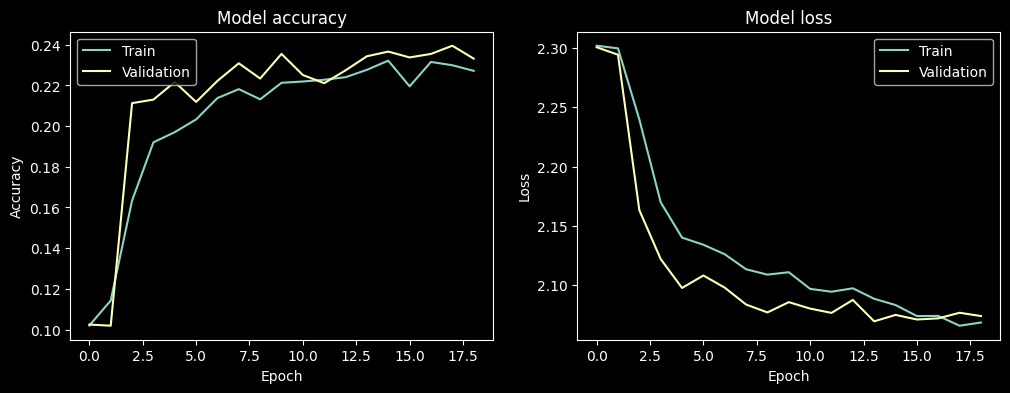

In [217]:
plot_history(history)

In [218]:
import tensorflow as tf

class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        
        self.conv1 = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        x = tf.keras.layers.add([inputs, x])
        x = self.relu(x)
        return x


In [219]:
def create_simple_resnet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Reshape((*input_shape, 1))(inputs)
    x = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = ResidualBlock(64, 3)(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = ResidualBlock(128, 3)(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)


In [220]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_data_np, train_labels_one_hot, epochs=50, batch_size=64, validation_data=(test_data_np, test_labels_one_hot), callbacks=[early_stopping])

Epoch 1/50
125/125 [==============================] - 11s 84ms/step - loss: 2.0850 - accuracy: 0.2307 - val_loss: 2.0838 - val_accuracy: 0.2349
Epoch 2/50
125/125 [==============================] - 10s 81ms/step - loss: 2.0824 - accuracy: 0.2320 - val_loss: 2.0758 - val_accuracy: 0.2234
Epoch 3/50
125/125 [==============================] - 10s 80ms/step - loss: 2.0722 - accuracy: 0.2279 - val_loss: 2.0767 - val_accuracy: 0.2355
Epoch 4/50
125/125 [==============================] - 10s 80ms/step - loss: 2.0737 - accuracy: 0.2314 - val_loss: 2.0830 - val_accuracy: 0.2406
Epoch 5/50
125/125 [==============================] - 10s 80ms/step - loss: 2.0732 - accuracy: 0.2264 - val_loss: 2.0700 - val_accuracy: 0.2372
Epoch 6/50
125/125 [==============================] - 10s 82ms/step - loss: 2.0591 - accuracy: 0.2428 - val_loss: 2.0643 - val_accuracy: 0.2280
Epoch 7/50
125/125 [==============================] - 10s 81ms/step - loss: 2.0633 - accuracy: 0.2472 - val_loss: 2.0706 - val_accuracy:

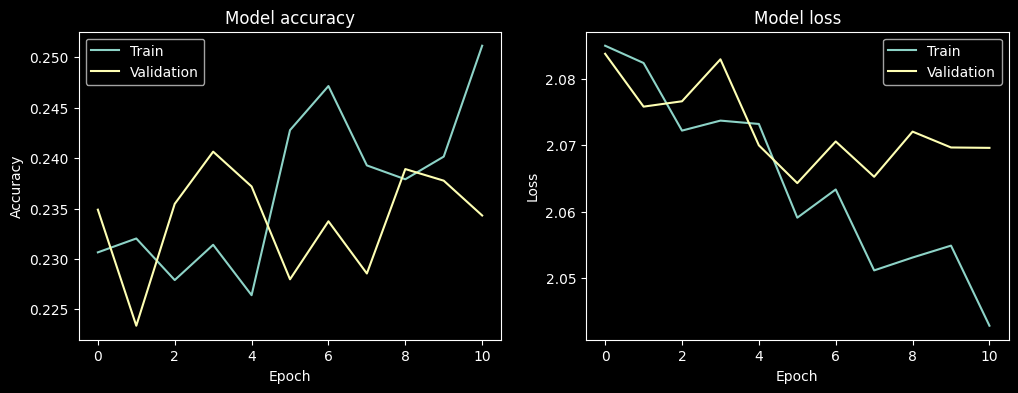

In [221]:
plot_history(history)

In [231]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256*2*2, activation='relu', input_shape=(384,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256*2, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [232]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_data_np, train_labels_one_hot, epochs=50, batch_size=64, validation_data=(test_data_np, test_labels_one_hot), callbacks=[early_stopping])

Epoch 1/50
125/125 [==============================] - 2s 12ms/step - loss: 2.3044 - accuracy: 0.1079 - val_loss: 2.2905 - val_accuracy: 0.1514
Epoch 2/50
125/125 [==============================] - 2s 12ms/step - loss: 2.2430 - accuracy: 0.1535 - val_loss: 2.1412 - val_accuracy: 0.1963
Epoch 3/50
125/125 [==============================] - 1s 11ms/step - loss: 2.1709 - accuracy: 0.1841 - val_loss: 2.0965 - val_accuracy: 0.2026
Epoch 4/50
125/125 [==============================] - 1s 12ms/step - loss: 2.1329 - accuracy: 0.2059 - val_loss: 2.0787 - val_accuracy: 0.2314
Epoch 5/50
125/125 [==============================] - 1s 12ms/step - loss: 2.1054 - accuracy: 0.2137 - val_loss: 2.0652 - val_accuracy: 0.2274
Epoch 6/50
125/125 [==============================] - 1s 10ms/step - loss: 2.0789 - accuracy: 0.2204 - val_loss: 2.0514 - val_accuracy: 0.2245
Epoch 7/50
125/125 [==============================] - 1s 11ms/step - loss: 2.0646 - accuracy: 0.2285 - val_loss: 2.0592 - val_accuracy: 0.2211

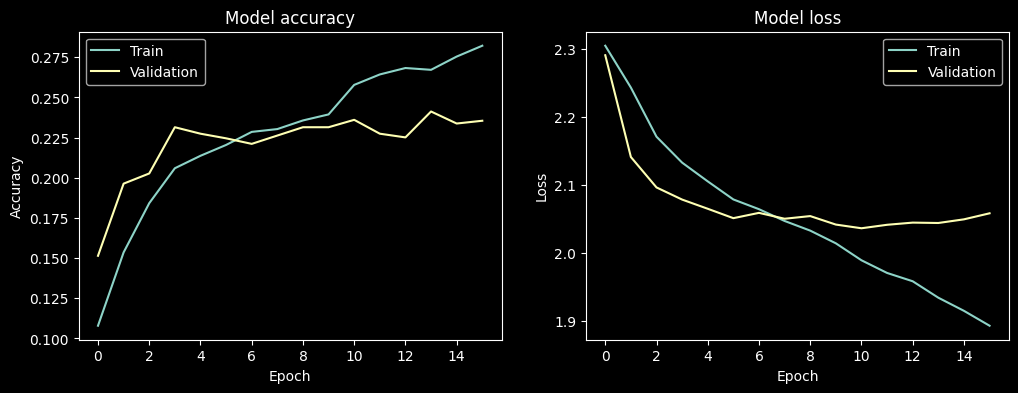

In [233]:
plot_history(history)

In [236]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold


In [237]:
def create_model(learning_rate, dropout_rate, num_units):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_units, activation='relu', input_shape=(384,)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units // 2, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [238]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=64, verbose=0)


In [239]:
search_space = {
    'learning_rate': Real(1e-5, 1e-2, prior='log-uniform'),
    'dropout_rate': Real(0.1, 0.5, prior='uniform'),
    'num_units': Integer(64, 256),
}

bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=search_space,
    n_iter=30,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
    random_state=42
)
